# HCP Gambling - rfMRI analysis

This analysis aims to show whether the ACT-R models prediction is also predictable by rsfMRI 

In [1]:
from __future__ import division
from lasso_func import *

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

----

### Load Correlation Data and Model Preidction

The dependent variable is the ACTR model prediction M1 or M2


In [2]:
power2011 = pd.read_csv('../bin/power_2011.csv', usecols=["ROI", "X", "Y", "Z", "Network", "Color", "NetworkName"]) 

# convert to 1/0 dummy variable 
model_dat = pd.read_csv('../actr-models/model_output/MODELLogLikelihood.csv')
model_dat['best_model1'] = np.where(model_dat['best_model']== 'm1', 1, 0)

---
### Load Subj Cocountivty Matrix

Next, convert many connectivity matries into a wide matrix `subj_wide`, with a dimension of `N`(number of subjects) x `M` (264 x 264 = 69696)

In [3]:
subj_wide = load_subj('./REST_corr/REST1/', model_dat)
DV = 'best_model1'  # define dependent variable(behavioral measurements) # DV = 'MLAT5' #MLAT5, alpha2, SymmetrySpan

And now, let’s visualize the histogram of the dependent variable we are trying to predict:

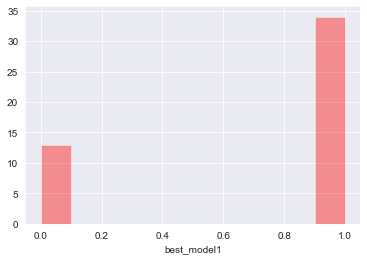

DV distribution:
 1    0.723404
0    0.276596
Name: best_model1, dtype: float64


In [4]:
sns.distplot(subj_wide[DV], kde=False, color='red', bins=10)
plt.show()

print('DV distribution:\n', subj_wide[DV].value_counts(normalize=True))

Imbalance training data might bias the logistic model, so we need to upsample the minority class by randomly adding more data from minrority class

In [6]:
subj_balance = balance_training_sample(subj_wide, DV)

# sns.distplot(subj_balance[DV], kde=False, color='red', bins=10)
# plt.show()

# print('DV distribution:\n', subj_wide[DV].value_counts(normalize=True))

### Define Brain Region of Interest

Exclude some brain regions. 

Now, we obtain connectivity vector for NOI by combining `censor` with `subj_censored`

In [7]:
# define network of interest (NOI)
NOI = [
        # "Uncertain",
        # "Sensory/somatomotor Hand",
        # "Sensory/somatomotor Mouth",
        "Cingulo-opercular Task Control",
        # "Auditory",
        "Default mode",
        "Memory retrieval?",
        "Ventral attention",
        # "Visual",
        "Fronto-parietal Task Control",
        # "Salience",
        "Subcortical",
        # "Cerebellar",
        "Dorsal attention"
]

In [8]:
censor = get_vector_df(power2011, NOI)        # filter some region connections
subj_censored = get_subj_df(subj_balance, censor)

features = list(subj_censored.columns)[2:]
print('The dimension of subj_censored is', subj_censored.shape, 'N = subj, M = connections')

The dimension of subj_censored is (68, 9047) N = subj, M = connections


---

### Logistic Regression Models

Here, we will use logistic regression with L1 penalty (LASSO) to identify the functional connectivity patterns that predict the ACT-R model outcome variable `best_model`: model1 / model2. To better fit in logistic model, this variable is changed to `best_model1` =  1/0


### Split training data and Testing set.

We will use leave-one-out to find best L1 parameter `lambda`

In [9]:
### 80% split
train_data, test_data = train_test_split(subj_censored, test_size=0.1, random_state=1)  # train: (50, 9046)\

#### Cross-Validation

Next, let's find the best `lambda_values` for Lasso Regression

Visualize the  `lambda` and `coef_` path

Best Score: 0.9672131147540983
Best Hyperparameters: {'C': 2.154434690031882}
Time usage: 91.354s


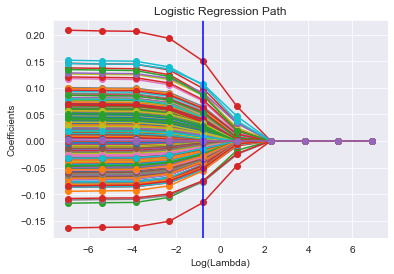

Time usage: 14.357s


In [10]:
grid_result = grid_search_lasso(train_data, features, DV, True)

In [18]:
# lambda_values = 1.0 / np.logspace(-3, 3, 10)
# best_lambda = 1.0 / 2.154434690031882
# plot_regularization_path(train_data, features, DV, lambda_values, best_lambda)

### Retrain Model

Next, we need to retrain the logistic model with best lambda `2.15`

Applying the cross-validation method (CV=20), we can evaluate the model accuracy 

In [11]:
#train_data, test_data = loocv_train_test_split_ith(subj_censored, 0)
best_lasso_model = LogisticRegression(penalty='l1', solver='saga', C=grid_result.best_params_['C'], fit_intercept=False)

In [12]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(best_lasso_model, subj_censored[features], subj_censored[DV],cv=20)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))   

0.97 accuracy with a standard deviation of 0.09


In [13]:
best_lasso_model.fit(subj_censored[features], subj_censored[DV])

LogisticRegression(C=2.154434690031882, fit_intercept=False, penalty='l1',
                   solver='saga')

ROC Accuracy Score for Logistic Regression:  1.0


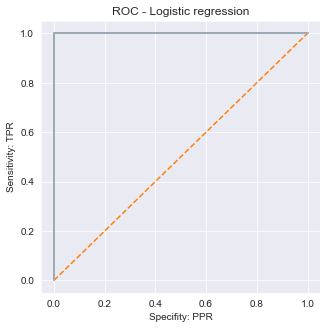

In [16]:
plot_ROC_curve(best_lasso_model, subj_censored, features, DV)

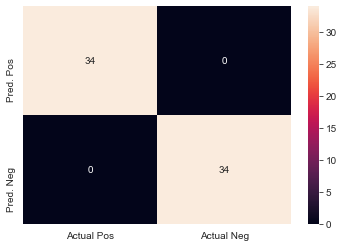

In [17]:
plot_confusion_matrix(best_lasso_model, subj_censored, features, DV)

In [25]:
### leave one out split
#train_data, test_data = loocv_train_test_split_ith(subj_censored, 0)
#print("Training data dimension: ", train_data.shape, "\nTesting data dimension: ", test_data.shape)

Let's look at strongest connections

In [32]:
betas = best_lasso_model.coef_[0]

min_connID = None
min_beta = betas[0]

max_connID = None
max_beta = betas[0]
for i in range(0, len(betas)):
    if betas[i] < min_beta:
        min_beta = betas[i]
        min_connID = features[i]
    if betas[i] > max_beta:
        max_beta = betas[i]
        max_connID = features[i]

print(min_connID, min_beta)
print(max_connID, max_beta)

[138, 188] -0.07186075949990861
[96, 200] 0.08837137051001469


### Prediction vs. Observed


Next, let's see the predict_proba vs. observation labels

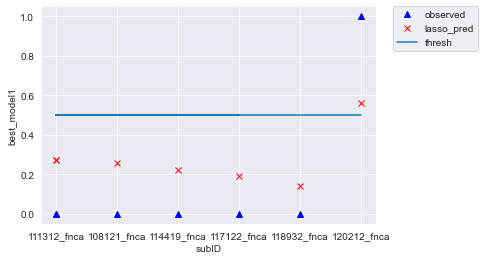

In [33]:
plot_prediction(subj_balance, test_data, features, DV, best_lasso_model)

### Brain Mapping

Next, look at the beta value mapped on brain 

In [34]:
censor['beta'] = best_lasso_model.coef_[0]

The beta distribution

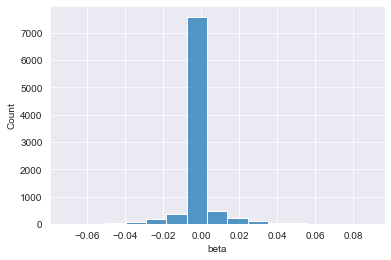

In [35]:
sns.histplot(data=censor, x='beta')
plt.show()

In [65]:
from nilearn import plotting
from nilearn import datasets

# prepare matrix
roi_df = get_ROI_df(power2011)
roi_df = roi_df.merge(censor, how="left", on = 'connID')
roi_df['beta'] = roi_df['beta'].replace(np.nan, 0)

adj_vector = roi_df['beta'].values
adj_beta = pd.DataFrame(vector2matrix(adj_vector), dtype='float')
#adj_matrix = np.identity(264)*.1
adj_matrix = np.zeros((264,264))

coor_vector = np.array([(0,0,0) for i in range(264)])
power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

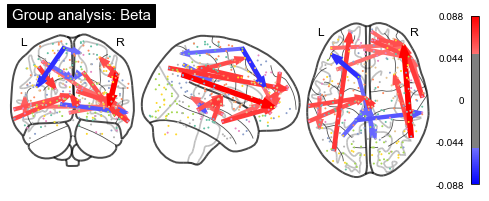

In [76]:
#grab center coordinates for atlas labels

# plot connectome with 80% edge strength in the connectivity

plotting.plot_connectome(adj_beta, power_coords,
                         edge_threshold=0.05,
                         colorbar=True,
                         node_size=1,
                         alpha=.2,
                         title='Group analysis: Beta')
plt.show()


In [77]:
plotting.view_connectome(adj_beta, power_coords, 
                         edge_threshold=0.05,
                         colorbar=True,
                         node_size=1,
                         title='Group analysis: Beta').open_in_browser()